# Lab: Alzheimer MRI Model  (Mohamed Ibn Khedher)

#### This notebook is inspired from [this link](https://www.kaggle.com/amyjang/alzheimer-mri-model-tensorflow-2-3-data-loading/notebook)

# Introduction

Machine learning has a phenomenal range of application in the health sciences. This tutorial will go over the complete pipeline to build a model that can determine the dementia level of an Alzheimer's patient from their MRI image.

This tutorial highlights the ease of building a CNN using `keras`. Additionally, TensorFlow 2.3 (or over) has new features, including easy data loading utilities that were previously not available in TensorFlow 2.2. We'll be seeing how easy data loading is with these additional features.

We'll be using a GPU accelerator for this NB.

**This notebook includes the following main steps:**

1. Upload data to colab (`.zip file`) 
2. Import librairies 
3. Data loading
3. Visualize data
4. Feature Engineering
5. Build the ML Model
6. Training the Model
7. Visualize Model Metrics
8. Model Evaluation 

**1. Upload data to colab (.zip file)**

First, Upload manually to data file `Alzheimer_sDataset.zip` to colab.

In [ ]:
# importing required modules
from zipfile import ZipFile
  
# specifying the zip file name
file_name = "/content/Alzheimer_sDataset.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
    # extracting all the files
    zip.extractall()
    print('Done!')

FileNotFoundError: ignored

**2. Load librairies**

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
#tf.compat.v1.disable_eager_execution()
#from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import PIL
import keras

Automatically, detect the platform of execution (CPU, GPU)


In [ ]:
### https://www.tensorflow.org/guide/distributed_training
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
AUTOTUNE = tf.data.experimental.AUTOTUNE 
print(tf.__version__)

Number of replicas: 1
2.9.2


Define parameters

In [ ]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [176, 208]

In [ ]:
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
NUM_CLASSES = len(class_names)

**3 Load a pretrained Model**

Upload manually the `alzheimer_model.h5` to colab

In [ ]:
model = keras.models.load_model('alzheimer_model.h5')
METRICS = [tf.keras.metrics.AUC(name='auc'),tf.keras.metrics.CategoricalAccuracy(name='acc')]
    
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

In [ ]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    image = tf.cast(image/255. ,tf.float64)
    return image, label

test_ds = tf.keras.utils.image_dataset_from_directory(
    "Alzheimer_s Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=2000,
    shuffle=False,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1279 files belonging to 4 classes.


In [ ]:
import tensorflow_datasets as tfds

for image, label in tfds.as_numpy(test_ds):
  labels = label
  images = image

## Interpretability

In [ ]:
#LXplique requires a version of python higher than 3.6 and several libraries including Tensorflow and Numpy. Installation can be done using Pypi:
!pip install xplique

In [ ]:
import xplique
from xplique.attributions import GradCAM, GradCAMPP,Saliency
from xplique.plots import plot_attributions
from xplique.metrics import Deletion

In [ ]:
parameters = {
    "model": model,
    "output_layer": -1,
    "batch_size": 16,
    "conv_layer": None,
}
explainer = Saliency(model)
# load images, labels and model

In [ ]:
explanations = explainer(images,labels )
# or just `explainer(images, labels)`

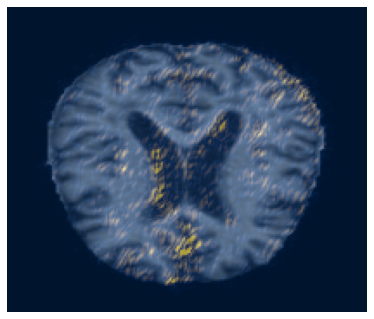

In [ ]:
# visualize explanation with plot_explanation() function
plot_attributions(tfds.as_numpy(explanations)[10].reshape([1]+IMAGE_SIZE),images[10].reshape([1]+IMAGE_SIZE+[3]), img_size=5, cmap='cividis', cols=1, alpha=0.6)

**Attributions Metrics** 

*In order to measure if the explanations provided by our method are faithful (it reflects well the functioning of the model) we can use a fidelity metric such as Deletion*

In [ ]:
metric = Deletion(model, images,labels )

score_saliency = metric(explanations)

In [ ]:
score_grad_cam

NameError: ignored